# train

In [1]:
import yaml
import os

with open("./config.yaml", 'rb') as f:
    config = yaml.load(f)

<ipython-input-1-1499ab5789c7>:5: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


In [2]:
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']
os.makedirs(OUTPUT_ROOT, exist_ok=True)

## load library

In [3]:
# python default library
import os
import shutil
import datetime
import sys
import pickle

# general analysis tool-kit
import numpy as np
import pandas as pd
#from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# pytorch
import torch
from torch import optim, nn
from torch.utils.tensorboard import SummaryWriter

#from torchsummary import summary

# etc
import yaml
yaml.warnings({'YAMLLoadWarning': False})

# original library
sys.path.append('/home/hiroki/research/dcase2021_task2/src/functions')
import common as com
import pytorch_modeler as modeler
from pytorch_model import ResNet38 as Model
#from pytorch_utils import filtered_load_model
#import models

import librosa
import IPython
import librosa.display

## load config and set logger

In [4]:
log_folder = config['IO_OPTION']['OUTPUT_ROOT']+'/run_extract_{0}.log'.format(datetime.date.today())
logger = com.setup_logger(log_folder, '00_train.py')

## Setting

In [5]:
# Setting seed
modeler.set_seed(42)

In [6]:
############################################################################
# Setting I/O path
############################################################################
# input dirs
INPUT_ROOT = config['IO_OPTION']['INPUT_ROOT']
dev_dir = INPUT_ROOT + "/dev_data"
add_dev_dir = INPUT_ROOT + "/add_dev_data"
# machine type
machine_types = os.listdir(dev_dir)
# output dirs
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']
MODEL_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/models'
TB_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/tb'
OUT_FEATURE_DIR = OUTPUT_ROOT + '/extraction_features'
#os.makedirs(OUTPUT_ROOT, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(TB_DIR, exist_ok=True)
os.makedirs(OUT_FEATURE_DIR, exist_ok=True)
# copy config
shutil.copy('./config.yaml', OUTPUT_ROOT)

'/media/hiroki/HDD1TB/research/dcase2021_task2/output/CNN_finetune/config.yaml'

In [7]:
torch.cuda.is_available()

True

## make path list

- __train_paths__ ([dict]): Each Machine Type
    - __ToyCar__ ([dict]): Each dataset
        - train ([list]) : paths
        - valid_source ([list]) : paths
        - valid_target ([list]) :paths
    - __ToyTrain__ ([dict]): Each dataset
        - train ([list]) : paths
        - valid_source ([list]) : paths
        - valid_target ([list]) : paths
    - ...

In [8]:
dev_paths = {}

for machine_type in machine_types:
    # dev train
    dev_train_paths = [f"{dev_dir}/{machine_type}/train/" + file for file in os.listdir(f"{dev_dir}/{machine_type}/train")]
    dev_train_paths = sorted(dev_train_paths)
    
    # add_dev train
    add_dev_paths = [f"{add_dev_dir}/{machine_type}/train/" + file for file in os.listdir(f"{add_dev_dir}/{machine_type}/train")]
    add_dev_paths = sorted(add_dev_paths)
    
    # dev_source valid
    dev_source_paths = [f"{dev_dir}/{machine_type}/source_test/" + file for file in os.listdir(f"{dev_dir}/{machine_type}/source_test")]
    dev_source_paths = sorted(dev_source_paths)
    
    # dev_target valid
    dev_target_paths = [f"{dev_dir}/{machine_type}/target_test/" + file for file in os.listdir(f"{dev_dir}/{machine_type}/target_test")]
    dev_target_paths = sorted(dev_target_paths)
    
    # bundle
    dev_paths[machine_type] = {}
    dev_paths[machine_type]['train'] = dev_train_paths + add_dev_paths
    dev_paths[machine_type]['valid_source'] = dev_source_paths
    dev_paths[machine_type]['valid_target'] = dev_target_paths

## training

In [9]:
#############################################################################
# run
#############################################################################
def run(machine_type, dev_paths):
    com.tic()
    
    logger.info('TARGET MACHINE_TYPE: {0}'.format(machine_type))
    logger.info('MAKE DATA_LOADER')
    # dataloader
    dataloaders_dict = modeler.make_dataloader(dev_paths, machine_type)
    # define writer for tensorbord
    #os.makedirs(TB_DIR+'/'+machine_type, exist_ok=True)
    #tb_log_dir = TB_DIR + '/' + machine_type
    #writer = SummaryWriter(log_dir = tb_log_dir)
    # model out path
    model_out_path = MODEL_DIR+'/{}_model.pth'.format(machine_type)
    logger.info('TRAINING')
    # parameter setting
    net = Model(sample_rate=config['param']['sample_rate'],
                window_size=config['param']['window_size'],
                hop_size=config['param']['hop_size'],
                mel_bins=config['param']['mel_bins'],
                fmin=config['param']['fmin'],
                fmax=config['param']['fmax'],
                classes_num=6
                )
    #optimizer = optim.Adam(net.parameters())
    #criterion = nn.CrossEntropyLoss()
    #num_epochs = config['param']['num_epochs']
    #scheduler = optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=1e2, 
    #                                          max_lr=1e-3, epochs=num_epochs, steps_per_epoch=len(dataloaders_dict['train']))
    # load pre-trained model
    pretrained_dict = torch.load(config['IO_OPTION']['PREMODEL_ROOT'])
    net.load_state_dict(pretrained_dict['model'], strict=False)
    # training
    output_dicts = modeler.extract_net(net, dataloaders_dict, optimizer, criterion, scheduler, num_epochs, writer, model_out_path)
    
    com.toc()

In [10]:
#############################################################################
# run
#############################################################################
def run(machine_type, dev_paths):
    com.tic()
    
    logger.info('TARGET MACHINE_TYPE: {0}'.format(machine_type))
    logger.info('MAKE DATA_LOADER')
    # dev_train_paths
    dataloaders_dict = modeler.make_dataloader(dev_paths, machine_type)
    # parameter setting
    logger.info('FEATURE EXTRACTION')
    net = Model(sample_rate=config['param']['sample_rate'],
                window_size=config['param']['window_size'],
                hop_size=config['param']['hop_size'],
                mel_bins=config['param']['mel_bins'],
                fmin=config['param']['fmin'],
                fmax=config['param']['fmax'],
                classes_num=6
               )
    pretrained_dict = torch.load(config['IO_OPTION']['PREMODEL_ROOT'])
    net.load_state_dict(pretrained_dict['model'], strict=False)
    output_dicts = modeler.extract_net(net, dataloaders_dict)
    out_path = f'{OUT_FEATURE_DIR}/{machine_type}_features.pkl'
    pd.to_pickle(output_dicts, out_path)
    logger.info(f'SAVE SUCCESS : {out_path}')
    
    com.toc()

In [11]:
machine_types

['fan', 'gearbox', 'pump', 'slider', 'ToyCar', 'ToyTrain', 'valve']

In [12]:
for machine_type in machine_types:
    run(machine_type, dev_paths)

2021-04-10 19:04:30,803 - 00_train.py - INFO - TARGET MACHINE_TYPE: fan
2021-04-10 19:04:30,804 - 00_train.py - INFO - MAKE DATA_LOADER
2021-04-10 19:04:30,805 - 00_train.py - INFO - FEATURE EXTRACTION
  0%|          | 0/48 [00:00<?, ?it/s]

use: cuda:0


100%|██████████| 5/5 [00:07<00:00,  1.51s/it]
2021-04-10 19:06:26,152 - 00_train.py - INFO - SAVE SUCCESS : /media/hiroki/HDD1TB/research/dcase2021_task2/output/CNN_finetune/extraction_features/fan_features.pkl
2021-04-10 19:06:26,154 - 00_train.py - INFO - TARGET MACHINE_TYPE: gearbox
2021-04-10 19:06:26,155 - 00_train.py - INFO - MAKE DATA_LOADER
2021-04-10 19:06:26,156 - 00_train.py - INFO - FEATURE EXTRACTION


elapsed time: 115.349855900 [sec]


  0%|          | 0/48 [00:00<?, ?it/s]

use: cuda:0


100%|██████████| 6/6 [00:09<00:00,  1.54s/it]
2021-04-10 19:08:58,965 - 00_train.py - INFO - SAVE SUCCESS : /media/hiroki/HDD1TB/research/dcase2021_task2/output/CNN_finetune/extraction_features/gearbox_features.pkl
2021-04-10 19:08:58,984 - 00_train.py - INFO - TARGET MACHINE_TYPE: pump
2021-04-10 19:08:58,985 - 00_train.py - INFO - MAKE DATA_LOADER
2021-04-10 19:08:58,986 - 00_train.py - INFO - FEATURE EXTRACTION


elapsed time: 152.824070692 [sec]


  0%|          | 0/48 [00:00<?, ?it/s]

use: cuda:0


100%|██████████| 5/5 [00:08<00:00,  1.75s/it]
2021-04-10 19:11:17,489 - 00_train.py - INFO - SAVE SUCCESS : /media/hiroki/HDD1TB/research/dcase2021_task2/output/CNN_finetune/extraction_features/pump_features.pkl
2021-04-10 19:11:17,493 - 00_train.py - INFO - TARGET MACHINE_TYPE: slider
2021-04-10 19:11:17,494 - 00_train.py - INFO - MAKE DATA_LOADER
2021-04-10 19:11:17,494 - 00_train.py - INFO - FEATURE EXTRACTION


elapsed time: 138.505494118 [sec]


  0%|          | 0/48 [00:00<?, ?it/s]

use: cuda:0


100%|██████████| 5/5 [00:08<00:00,  1.79s/it]
2021-04-10 19:13:50,812 - 00_train.py - INFO - SAVE SUCCESS : /media/hiroki/HDD1TB/research/dcase2021_task2/output/CNN_finetune/extraction_features/slider_features.pkl
2021-04-10 19:13:50,819 - 00_train.py - INFO - TARGET MACHINE_TYPE: ToyCar
2021-04-10 19:13:50,820 - 00_train.py - INFO - MAKE DATA_LOADER
2021-04-10 19:13:50,820 - 00_train.py - INFO - FEATURE EXTRACTION


elapsed time: 153.319641590 [sec]


  0%|          | 0/48 [00:00<?, ?it/s]

use: cuda:0


100%|██████████| 5/5 [00:08<00:00,  1.75s/it]
2021-04-10 19:16:06,084 - 00_train.py - INFO - SAVE SUCCESS : /media/hiroki/HDD1TB/research/dcase2021_task2/output/CNN_finetune/extraction_features/ToyCar_features.pkl
2021-04-10 19:16:06,102 - 00_train.py - INFO - TARGET MACHINE_TYPE: ToyTrain
2021-04-10 19:16:06,103 - 00_train.py - INFO - MAKE DATA_LOADER
2021-04-10 19:16:06,104 - 00_train.py - INFO - FEATURE EXTRACTION


elapsed time: 135.278133392 [sec]


  0%|          | 0/48 [00:00<?, ?it/s]

use: cuda:0


100%|██████████| 5/5 [00:08<00:00,  1.62s/it]
2021-04-10 19:18:23,919 - 00_train.py - INFO - SAVE SUCCESS : /media/hiroki/HDD1TB/research/dcase2021_task2/output/CNN_finetune/extraction_features/ToyTrain_features.pkl
2021-04-10 19:18:23,923 - 00_train.py - INFO - TARGET MACHINE_TYPE: valve
2021-04-10 19:18:23,923 - 00_train.py - INFO - MAKE DATA_LOADER
2021-04-10 19:18:23,924 - 00_train.py - INFO - FEATURE EXTRACTION


elapsed time: 137.817241192 [sec]


  0%|          | 0/48 [00:00<?, ?it/s]

use: cuda:0


100%|██████████| 5/5 [00:08<00:00,  1.62s/it]
2021-04-10 19:20:55,833 - 00_train.py - INFO - SAVE SUCCESS : /media/hiroki/HDD1TB/research/dcase2021_task2/output/CNN_finetune/extraction_features/valve_features.pkl


elapsed time: 151.911427021 [sec]


In [13]:
machine_type = 'pump'
input_path = f'{OUT_FEATURE_DIR}/{machine_type}_features.pkl'
ext_data = pd.read_pickle(input_path)

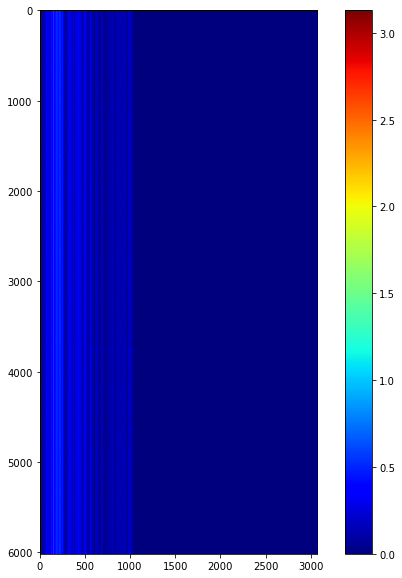

In [14]:
plt.figure(figsize=(10,10))
plt.imshow(ext_data['train']['features'], cmap='jet')
plt.colorbar()

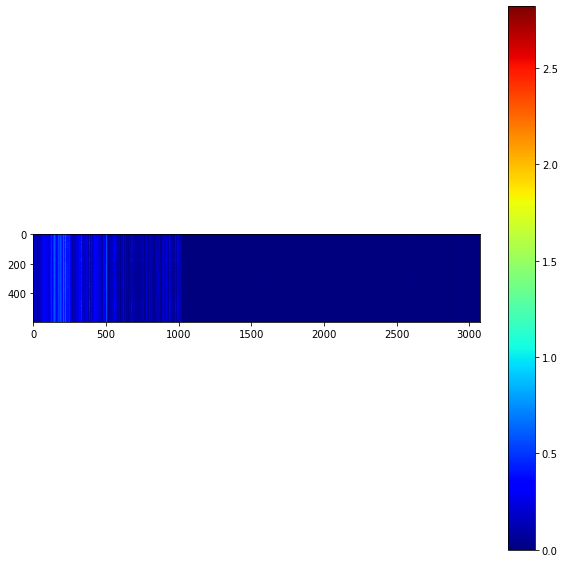

In [15]:
plt.figure(figsize=(10,10))
plt.imshow(ext_data['valid_source']['features'], cmap='jet')
plt.colorbar()

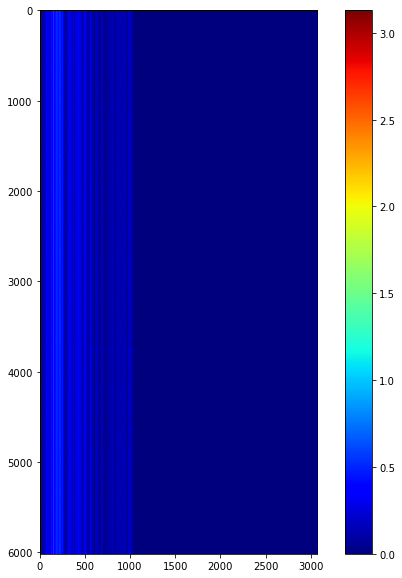

In [16]:
plt.figure(figsize=(10,10))
plt.imshow(ext_data['train']['features'], cmap='jet')
plt.colorbar()

history = run('ToyCar')
with open('{}/{}_history.pkl'.format(PKL_DIR, machine_type), 'wb') as file:
    pickle.dump(history , file)

In [17]:
print(M_means.shape)
plt.imshow(M_means, aspect='auto', cmap='jet')
plt.title(phase)
plt.colorbar()
plt.show()

NameError: name 'M_means' is not defined